# Project 11 - Building a low volatility indicator of Chinese A-stocks
## Project background
Low volatility can be a very effective predictor for future returns in China A- shares market.  However, we have observed that we need to carefully understand and build a low volatility signal that is indicative of not only a stock’s current volatility, but also its future volatility. 

[MSCI Article](https://www.msci.com/www/blog-posts/how-the-low-volatility-factor/01132841955)

## Project aim & deliverables
We would like to build a company-level predictive model for identifying stocks with low future volatility. We will look to combine company fundamental data (from the income statement and balance sheet) with trailing volatility and return information to build a better forecast for future volatility of a company.

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

#from datascience import *
#%matplotlib inline
#import matplotlib.pyplot as plots
#plots.style.use('fivethirtyeight')
#import numpy as np

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Read file from google drive
downloaded = drive.CreateFile({'id':'17I1DjtnRL4Fd24GQE9qsnufFksfJ5_wz'}) 
downloaded.GetContentFile('China_A_200101_201906.csv')  
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
china_stocks = pd.read_csv('China_A_200101_201906.csv', parse_dates=['py_month_end'], date_parser=dateparser)

# Convert data types
china_stocks['cxrf'] = china_stocks.cxrf.astype('category')
china_stocks['economic_sector_group'] = china_stocks.economic_sector_group.astype('category')
china_stocks['industry_group'] = china_stocks.industry_group.astype('category')
china_stocks['market'] = china_stocks.market.astype('category')

china_stocks.dtypes

cxrf                           category
total_ror                       float64
a_p                             float64
accr                            float64
agro                            float64
                              ...      
stvi_cwcnorm                    float64
industry_group                 category
economic_sector_group          category
market                         category
py_month_end             datetime64[ns]
Length: 78, dtype: object

## Cleaning data

In order to find the volatility of a stock, it is imperative that we have sufficient entries to take the standard deviation from. Hence, for each company (under the column *cxrf*), let's take a look at how much data we have. This function will find the number of unique entries for each company. 

# WRITE ASSUMPTIONS DOWN HOW MANY OBERSERVATIONS WE NEED TO FEEL CONFIDENT ABOUT OUR ANALYSIS

In [0]:
## Keep the companies with a full data set
# Count the number of occurences of each value (company) in the cxrf col
counts_of_companies = china_stocks['cxrf'].value_counts()

# Number of companies with 222 counts of data
full_data_coy = counts_of_companies[counts_of_companies == counts_of_companies.max()].index.tolist()

# Create new dataframe for companies will full set of data
china_stocks_large = china_stocks.loc[china_stocks['cxrf'].isin(full_data_coy)]
china_stocks_large.head()

,cxrf,total_ror,a_p,accr,agro,aroe,asst_risk,blev,bps,btop_risk,calf,cflow,ctop,dcut,dsuseh,dtoa,e_p,epsn,erhp,erv3,erv6,etop_risk,flsn,funq,grex,gro5,grot,hbet,hsig,ogro,optp,PAIM,pncv,rasr,rosa,rstr,size,stvi,a_p_cwcnorm,accr_cwcnorm,agro_cwcnorm,aroe_cwcnorm,asst_risk_cwcnorm,blev_cwcnorm,bps_cwcnorm,btop_risk_cwcnorm,calf_cwcnorm,cflow_cwcnorm,ctop_cwcnorm,dcut_cwcnorm,dsuseh_cwcnorm,dtoa_cwcnorm,e_p_cwcnorm,epsn_cwcnorm,erhp_cwcnorm,erv3_cwcnorm,erv6_cwcnorm,etop_risk_cwcnorm,flsn_cwcnorm,funq_cwcnorm,grex_cwcnorm,gro5_cwcnorm,grot_cwcnorm,hbet_cwcnorm,hsig_cwcnorm,ogro_cwcnorm,optp_cwcnorm,PAIM_cwcnorm,pncv_cwcnorm,rasr_cwcnorm,rosa_cwcnorm,rstr_cwcnorm,size_cwcnorm,stvi_cwcnorm,industry_group,economic_sector_group,market,py_month_end
0,3544,0.932785,NaN,0.007104,0.076045,0.233325,6.940010,1.295927,1.899177,0.485723,NaN,0.133751,0.034207,0.218426,0.0,0.183807,-1.707984,-1.635143,0.007949,0.0,NaN,0.027104,-0.474038,-0.527620,-0.325025,-0.325025,-4.073564,0.827880,0.411321,-0.026694,0.034329,0.000000e+00,0.000000,0.904039,0.012259,-0.863091,-3.040299,0.125892,NaN,NaN,-0.825850,-4.000000,-2.132087,-0.265410,NaN,0.145839,NaN,NaN,-1.174434,0.395825,0.417823,0.000237,-1.953154,-1.936157,-1.899854,-0.653403,NaN,-0.968106,-0.516036,-1.339153,-1.685044,-1.601335,-2.714745,0.109318,0.307726,-0.765732,-1.238542,-0.161009,-0.218481,1.788768,NaN,-0.898490,-3.112868,-0.777881,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,CN,2011-05-31
1,3544,0.900325,NaN,0.010521,0.076269,0.212320,6.971717,1.292808,1.959875,0.742377,NaN,0.138057,0.052294,0.227541,0.0,0.187509,-1.543444,-1.419654,0.008732,0.0,NaN,0.041773,-0.292163,-0.422266,-0.309311,-0.309311,-2.798569,0.899509,0.322761,-0.041754,0.048115,0.000000e+00,0.000000,0.209649,0.009434,-1.141599,-3.303436,0.198699,NaN,NaN,-0.848168,0.244434,-2.243277,-0.328487,NaN,0.472820,NaN,NaN,-0.952286,0.475080,0.754139,-0.081088,-1.790761,-1.646030,-1.778410,0.385864,NaN,-0.724689,-0.325725,-1.174100,-1.509798,-1.483511,-2.101453,0.181886,-0.393239,-0.795912,-1.131231,-0.145678,-0.197752,-0.759962,NaN,-1.171224,-3.382034,-0.143845,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,CN,2012-03-31
2,3544,0.956208,NaN,0.016860,0.089016,0.196017,6.767115,1.592630,1.692062,0.333740,NaN,0.152586,0.030096,0.287019,0.0,0.291708,-1.624168,-1.526004,0.014556,0.0,NaN,0.013236,0.415446,-0.310161,-0.184189,-0.184189,-2.148597,0.814310,0.421699,0.038484,0.037684,4.063416e-14,0.000000,0.925528,0.025792,0.107220,-3.017604,0.322125,NaN,NaN,-0.615493,-0.153322,-2.139696,0.163369,NaN,-0.251454,NaN,NaN,-1.059866,0.824199,0.422096,0.597091,-1.908962,-1.714063,-1.548894,-0.073165,NaN,-1.072378,0.478183,-0.882071,-0.997968,-1.014456,-1.703851,0.120127,0.266092,-0.299242,-1.048251,-0.203345,-0.311327,1.879610,NaN,0.110237,-3.089693,1.368798,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,CN,2010-05-31
3,3544,0.967343,NaN,0.014515,0.089016,0.212644,6.770250,1.590266,1.306799,0.288477,NaN,0.117374,0.025910,0.269155,0.0,0.291708,-1.733498,-1.772672,0.012722,0.0,NaN,0.011395,0.388900,-0.345807,-0.191830,-0.191830,-2.370033,0.817586,0.413396,0.032964,0.032443,1.199041e-14,0.000000,0.908008,0.025792,0.006949,-2.891008,0.464894,NaN,NaN,-0.681081,0.055450,-2.062086,0.167831,NaN,-0.456504,NaN,NaN,-1.199352,0.809854,0.422005,0.595285,-2.004678,-2.031466,-1.682165,0.098648,NaN,-1.194100,0.455513,-0.962321,-1.024454,-0.981325,-1.839107,0.113984,0.240389,-0.336344,-1.127907,-0.217355,-0.261295,1.783166,NaN,0.007341,-2.962512,4.073888,"PHOTOOPTICAL,MICROS,OFFC.MCH.",TECH,CN,2010-08-31
4,3544,1.034951,NaN,0.004031,0.282085,0.130918,5.683209,3.060559,1.661175,0.147923,NaN,0.277160,0.024680,0.292755,0.0,0.525219,-1.117937,-1.098821,0.015057,0.0,NaN,0.020650,2.435869,0.154224,0.290746,0.290746,1.703079,1.547745,0.443263,0.346222,0.024228,3.221867e-13,0.128394,0.775386,0.083236,-1.010954,-2.827588,0.272950,NaN,NaN,0.644720,-0.742708,-2.047553,3.000000,NaN,-1.114918,NaN,NaN,-1.225016,1.215597,0.468684,2.071325,-1.272106,-1.010720,-1.057111,-1.247019,NaN,-0.673585,2.666285,0.21297

In [0]:
# china_stocks_large.loc[china_stocks_large.cxrf == 3544][['cxrf','total_ror','py_month_end']].sort_values(by=['py_month_end'])

In [0]:
# presentation_analysis_df = china_stocks_large.iloc[:,0:20]
# presentation_analysis_df_2 = china_stocks_large.iloc[:,-4:-1]
# new_p = pd.concat([presentation_analysis_df,presentation_analysis_df_2],axis=1)
    
#     # drop(china_stocks_large.loc[[38,74]], axis=0)
# new_p

In [0]:
# from google.colab import files
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(new_p)
# profile

In [0]:
# profile.to_file("Project 11.html")

# import os
# os.listdir()

In [0]:
# files.download('Project 11.html')

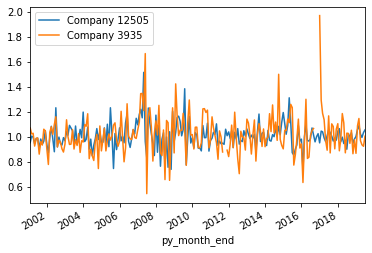

In [0]:
%matplotlib inline

# Create a dataframe of total_ror for cxrf 3935
coy_3935 = china_stocks_large.loc[china_stocks_large['cxrf'] == 3935]
ax = coy_3935.plot(x='py_month_end',y='total_ror')

# Create a dataframe of total_ror for cxrf 12505
coy_12505 = china_stocks_large.loc[china_stocks_large['cxrf'] == 12505]
coy_12505.plot(x='py_month_end',y='total_ror', ax=ax)
ax.legend(["Company 12505", "Company 3935"])

## Variance
From the above graph, we can visually understand the difference in the variance of both companies - company 3935 is larger. This variation can be calculated mathematically as well. 

$$\sigma_{year}^2 = \sum_{t=1}^{12}\frac{(R_t-\bar{R}_t)^2}{n-1}$$

Here, $x$ refers to the returns for the month while $\bar{x}$ refers to the mean of the returns for each month of the year. 

In [0]:
# Create a function for the formula above
def variance(x):
  sum_ = 0
  mean_ = x.mean()
  count_ = x.count()
  for index, row in x.items():
    sum_ += (row - mean_)**2/(count_-1)
  # print(sum_)
  return sum_

In [0]:
# Find the variance of cxrf 3935 for each year
coy_3935['year'] = coy_3935['py_month_end'].dt.year
std_coy_3935 = coy_3935.groupby('year')['total_ror'].agg(variance)


# Find the variance of cxrf 12505 for each year
coy_12505['year'] = coy_12505['py_month_end'].dt.year
std_coy_12505 = coy_12505.groupby('year')['total_ror'].agg(variance)

# Combine the two files to compare the variance
standard_deviations = pd.concat([std_coy_3935,std_coy_12505],axis=1)
standard_deviations.columns=['Company 3935','Company 12505']

# # Append a total row and display results
# standard_deviations.loc['Total'] = standard_deviations.sum()
# standard_deviations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
std_coy_3935

year
2001    0.001470
2002    0.009470
2003    0.005314
2004    0.004284
2005    0.014876
2006    0.007238
2007    0.036551
2008    0.023033
2009    0.022416
2010    0.005963
2011    0.003012
2012    0.002543
2013    0.004913
2014    0.005268
2015    0.016927
2016    0.008061
2017    0.001116
2018    0.001985
2019    0.001078
Name: total_ror, dtype: float64

## Applying time series methods to unknown variables

We can conduct time series analysis to the variables that we are unfamiliar with, namely autocorrelations and plotting the ACF graphs, and running the Augmented Dickey-Fuller Test to obtain the p value to check if these variables follow a random walk.


In [0]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

coy_3935_edited = coy_3935.set_index('py_month_end').sort_index()
coy_3935_edited.info()

NameError: ignored

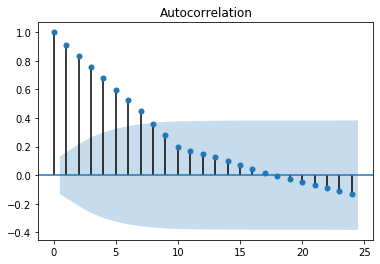

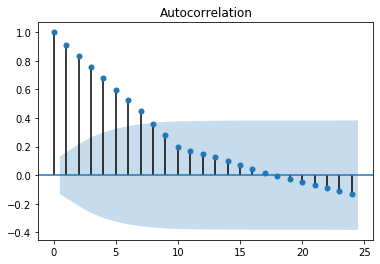

In [0]:
plot_acf(coy_3935_edited['accr'],alpha=0.05)

In [0]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

auto_corr_series = pd.Series()
adfuller_series = pd.Series()

for col_name,column in coy_3935_edited.iteritems():
    try:
        auto_corr_series[col_name] = column.autocorr(lag=1)
    except:
        auto_corr_series[col_name] = np.NaN
    try:
        adfuller_series[col_name] = adfuller(column)[1]
    except:
        adfuller_series[col_name] = np.NaN

anlaysis_results = pd.DataFrame(list(zip(auto_corr_series, adfuller_series)))
anlaysis_results.columns = ['auto_corr_series','adfuller_series']
anlaysis_results.set_index(auto_corr_series.index).dropna().head()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,auto_corr_series,adfuller_series
total_ror,0.005937,0.000018
accr,0.913979,0.088716
agro,0.981539,0.000156
aroe,0.980767,0.200953
asst_risk,0.998481,0.005427


Different package below....

In [0]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import matplotlib.pylab as plt


In [5]:
companies=Table.read_table('China_A_200101_201906.csv')


FileNotFoundError: ignored

In [6]:
industry_names=companies.group('industry_group').column('industry_group')
industry_names

NameError: ignored

In [0]:
def group_industry_bymonth(industry):
  industry_ror=companies.select('industry_group','total_ror','py_month_end').where('industry_group', industry)
  return industry_ror.drop('industry_group').group('py_month_end',np.nanmean).sort('py_month_end')
# group_industry_bymonth('WHOLESALE')

In [0]:
def industry_with_rolling(industry):
  print('Industry name:' + industry)
  ror=group_industry_bymonth(industry).column('total_ror nanmean')
  rolling_std=make_array()
  for i in range(len(ror)):
    indices=np.arange(i,i+11)
    if i >= len(ror)-11:
      indices=np.arange(i,len(ror))
      rolling_std=np.append(rolling_std, np.nanstd(np.take(ror, indices)))
    else:
      rolling_std=np.append(rolling_std, np.nanstd(np.take(ror, indices)))
  industry_with_rollingstd=group_industry_bymonth(industry).with_column('rolling_std', rolling_std)
  print('rolling std')
  return  rolling_std

len(industry_with_rolling('IT HARDWARE'))


Industry name:IT HARDWARE
rolling std


222

Industry name:BEER,LIQUOR, AND TOBACCO
rolling std
Industry name:IT HARDWARE
rolling std
Industry name:GAS AND OTHER PUBLIC UTILITIES
rolling std


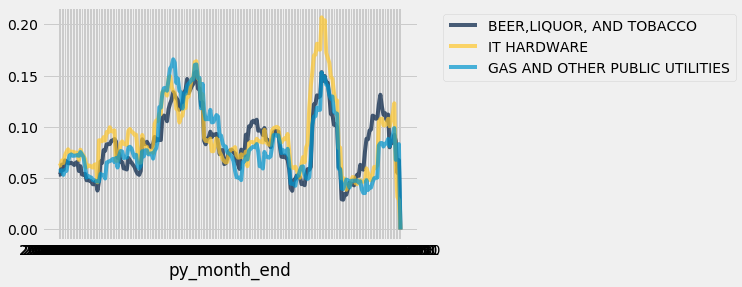

In [0]:
plot_com=companies.group('py_month_end').select('py_month_end').with_columns('BEER,LIQUOR, AND TOBACCO', industry_with_rolling('BEER,LIQUOR, AND TOBACCO'), 'IT HARDWARE', industry_with_rolling('IT HARDWARE'), 'GAS AND OTHER PUBLIC UTILITIES', industry_with_rolling('GAS AND OTHER PUBLIC UTILITIES'))
plot_com.plot('py_month_end')

Industry name:SOFTWARE
rolling std
Industry name:WHOLESALE
rolling std
Industry name:AIRLINES
rolling std


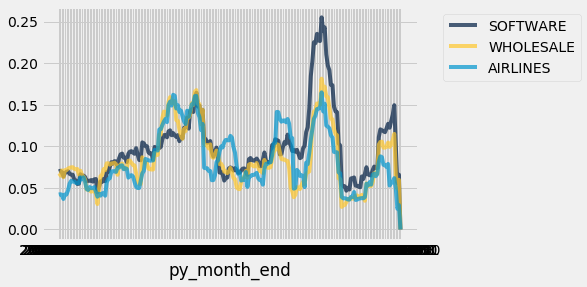

In [0]:
plot_com=companies.group('py_month_end').select('py_month_end').with_column('SOFTWARE', industry_with_rolling('SOFTWARE'), 'WHOLESALE', industry_with_rolling('WHOLESALE'), 'AIRLINES', industry_with_rolling('AIRLINES'))
plot_com.plot('py_month_end')

In [0]:
group_month=companies.select('py_month_end', 'total_ror').group('py_month_end', np.nanmean)
month_ror=group_month.column('total_ror nanmean')
rolling_std=make_array()
for i in range(len(month_ror)):
  indices=np.arange(i,i+11)
  if i >= len(month_ror)-11:
    indices=np.arange(i,len(month_ror))
    rolling_std=np.append(rolling_std, np.nanstd(np.take(month_ror, indices)))
  else:
    rolling_std=np.append(rolling_std, np.nanstd(np.take(month_ror, indices)))

len(rolling_std)


222

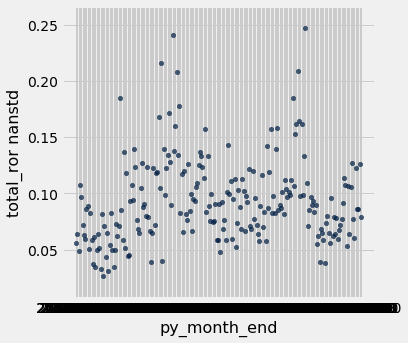

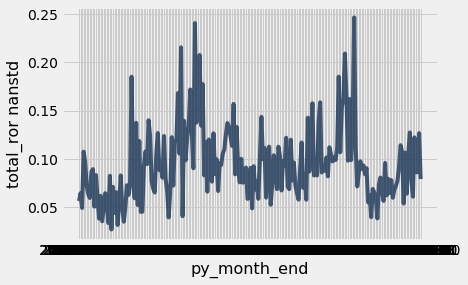

In [0]:
def plot_industry(x):
  table=companies.where('industry_group',x).select('py_month_end', 'total_ror').group('py_month_end', np.nanstd)
  table.scatter(0)
  table.plot(0)
  return
plot_industry('WHOLESALE')

The two peaks in the graph show high ror standard deviation which mean the ror are abnomally unstable. what happened? Check the time period when the ror st are larger than 0.2. interestingly they are 2008 and 2015


In [0]:
# find_industry('WHOLESALE').group('py_month_end', np.nanstd).where('total_ror nanstd', are.above(0.2))

How about another industry? lets try industry 'testiles and apparel'

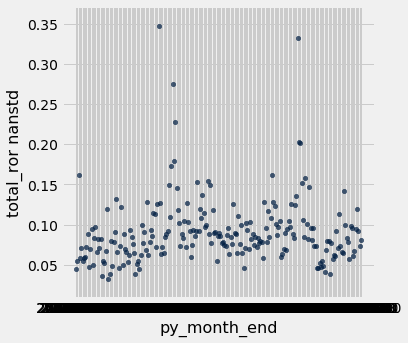

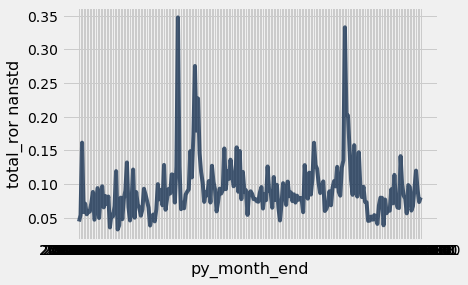

In [0]:
plot_industry('TEXTILES AND APPAREL')

In [0]:
find_industry('TEXTILES AND APPAREL').group('py_month_end',np.nanstd).where('total_ror nanstd', are.above(0.2))

NameError: ignored

How about information, services industry?

In [0]:
plot_industry('INFORMATION, SERVICES')

In [0]:
find_industry('INFORMATION, SERVICES').group('py_month_end',np.nanstd).where('total_ror nanstd', are.above(0.2))

2008 and 2015 again. Seems like all the industries have very volatile ror during that two periods of time

In [0]:
rolling_array_table=companies.where('cxrf', 3544).select('total_ror', 'py_month_end').sort('py_month_end')
rolling_array_table


In [0]:
rolling_2001=rolling_array_table.where('py_month_end', are.containing('2001'))

In [0]:
std_array=np.nanstd(rolling_2001.column('total_ror'))
std_array

Try seasonal exponential smoothing


In [7]:
seasonal=Table.read_table('rolling_3544.csv')
seasonal

cxrf,total_ror,a_p,accr,agro,aroe,asst_risk,blev,bps,btop_risk,calf,cflow,ctop,dcut,dsuseh,dtoa,e_p,epsn,erhp,erv3,erv6,etop_risk,flsn,funq,grex,gro5,grot,hbet,hsig,ogro,optp,PAIM,pncv,rasr,rosa,rstr,size,stvi,a_p_cwcnorm,accr_cwcnorm,agro_cwcnorm,aroe_cwcnorm,asst_risk_cwcnorm,blev_cwcnorm,bps_cwcnorm,btop_risk_cwcnorm,calf_cwcnorm,cflow_cwcnorm,ctop_cwcnorm,dcut_cwcnorm,dsuseh_cwcnorm,dtoa_cwcnorm,e_p_cwcnorm,epsn_cwcnorm,erhp_cwcnorm,erv3_cwcnorm,erv6_cwcnorm,etop_risk_cwcnorm,flsn_cwcnorm,funq_cwcnorm,grex_cwcnorm,gro5_cwcnorm,grot_cwcnorm,hbet_cwcnorm,hsig_cwcnorm,ogro_cwcnorm,optp_cwcnorm,PAIM_cwcnorm,pncv_cwcnorm,rasr_cwcnorm,rosa_cwcnorm,rstr_cwcnorm,size_cwcnorm,stvi_cwcnorm,industry_group,economic_sector_group,market,py_month_end,std_january,rolling_January,std_feb,rolling_feb,Unnamed: 82,new_rollingstd_last_12,single_seasonal,errro,single,double..,An,Bn,error1,error2,Unnamed: 92,Unnamed: 93,Unnamed: 94
3544,1.001,nan,0.00103876,0.114053,0.135233,4.62364,1.68303,2.19656,0.0793269,nan,0.210177,0.00759037,0.366023,0,0.332052,-0.938069,-0.625111,0.016236,0,nan,0.0065516,0.667568,0.327547,0.0278563,0.0278563,1.90252,1.50949,0.47685,0.176795,0.00984339,0,0.0847212,0.248049,0.0893394,0.140952,-2.93361,0.125801,nan,nan,-0.560299,-0.616823,-2.42916,0.451944,nan,-0.793489,nan,nan,-0.947249,3.24492,0.883113,0.772592,-0.986211,-0.62186,-0.566819,0.50257,nan,-0.907737,0.800801,0.702816,0.210026,0.0337768,0.473968,1.68108,0.010815,0.382354,-0.979849,-0.213511,-0.0755596,-0.738647,nan,0.144757,-3.02948,-1.33536,WHOLESALE,BUSINSRV,CN,31/1/2001,0.118362,0.118362,0.132242339,0.132242339,nan,0.118361534,0.118362,nan,0.134342,nan,0.134342,0,nan,nan,nan,alpha,nan
3544,0.86963,nan,0.00119449,0.114053,0.151998,4.62365,1.67836,2.21168,0.0918472,nan,0.210177,0.00872829,0.376197,0,0.332052,-1.04786,-0.671227,0.0172624,0,nan,0.0075338,0.635533,0.195193,0.0214741,0.0214741,1.20005,1.52236,0.479123,0.208434,0.0113191,0,0.107208,0.266241,0.0893394,-0.319937,-2.92452,0.222501,nan,nan,-0.549004,0.359296,-2.5237,0.396787,nan,-0.887772,nan,nan,-1.0512,3.29569,0.704238,0.733899,-1.0893,-0.69769,-0.668607,0.844641,nan,-1.05836,0.744824,0.401623,0.0713405,-0.178408,0.177794,1.64856,0.0542178,0.489912,-1.11861,-0.213567,0.0153207,-0.639962,nan,-0.326769,-3.01222,-0.284339,WHOLESALE,BUSINSRV,CN,28/2/2001,0.132242,0.118362,0.128446277,0.132242339,nan,0.132242339,0.132242,nan,0.134342,0.134342,0.134342,0,0,0,nan,0,nan
3544,1.16495,nan,0.00102543,0.114053,0.140235,4.62372,1.67375,2.2268,0.0793867,nan,0.210177,0.00749295,0.363646,0,0.332052,-1.03837,-0.670482,0.0162836,0,nan,0.00646752,0.499637,0.253163,0.0214741,0.0214741,1.20005,1.52811,0.478482,0.208434,0.00971706,0,0.107208,0.221176,0.0893394,-0.31434,-2.44244,0.225439,nan,nan,-0.439557,-0.107181,-2.27269,0.356104,nan,-0.90096,nan,nan,-1.01497,2.71983,0.466324,0.728487,-1.09231,-0.7686,-0.645335,0.265088,nan,-0.991621,0.631366,0.593765,0.41743,0.0843819,0.303457,1.53431,-0.0759264,0.765794,-1.11697,-0.226458,-0.196072,-0.806926,nan,-0.319787,-2.53505,-0.539222,WHOLESALE,BUSINSRV,CN,31/3/2001,0.128446,0.121138,0.121802504,0.131483127,nan,0.128446277,0.128446,nan,0.134342,0.134342,0.134342,0,0,0,nan,0,1
3544,1.24777,nan,0.0015202,0.138339,0.144087,5.0633,1.88366,2.99546,0.0855845,nan,0.722085,0.020631,0.291766,0,0.377459,-0.521811,-0.165428,0.0251765,0,nan,0.0191108,0.79813,0.581724,0.348571,0.348571,1.76159,1.59069,0.483528,0.344889,0.0202353,2.9e-13,0.0247893,0.277139,0.221948,0.0773212,-2.25892,0.253262,nan,nan,-0.325503,-0.196402,-1.93084,0.858983,nan,-0.938223,nan,nan,-0.631312,1.52242,0.485409,1.07206,-0.467882,-0.0795013,-0.365945,0.0885665,nan,-0.596014,0.881479,1.2146,1.20883,0.87618,0.428489,1.73457,-0.0962808,1.09829,-0.843657,-0.224773,-0.46695,-0.598997,nan,0.0786333,-2.3416,-0.449107,MAINFRAME & MINICOMPUTERS,TECH,CN,30/4/2001,0.121803,0.122599,0.094121552,0.129547002,nan,0.121802504,0.121803,nan,0.134342,0.134342,0.134704,0.000289487,0.00109654,0.000361859,nan,nan,nan
3544,0.994054,nan,0.001

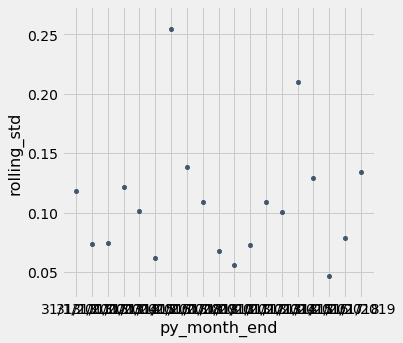

In [8]:
seasonal_selected=seasonal.select('cxrf', 'total_ror', 'py_month_end', 'new_rollingstd_last_12', 'single_seasonal').take(np.arange(221))
#jan.select('py_month_end','new_rollingstd_last_12')
convert_type=make_array()
for i in seasonal_selected.column('new_rollingstd_last_12'):
  convert_type=np.append(convert_type, float(i)) 
seasonal_selected=seasonal_selected.drop('new_rollingstd_last_12').with_column('rolling_std',convert_type)
jan=seasonal_selected.where('py_month_end', are.containing('/1/'))
jan.select('py_month_end', 'rolling_std').scatter('py_month_end')


In [0]:
def month_table(t):
  float_std=make_array()
  for i in t.column('new_rollingstd_last_12'):
    float_std=np.append(float_std, float(i))
  t=t.drop('new_rollingstd_last_12').with_column('rolling_std',float_std)
  return t

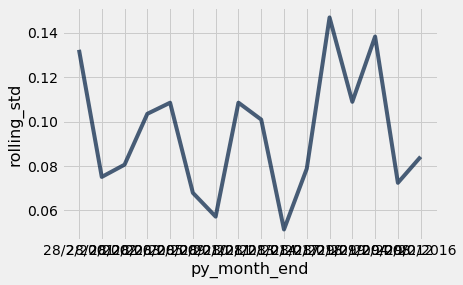

In [10]:
feb=seasonal_selected.where('py_month_end', are.containing('/2/'))

feb.select('py_month_end', 'rolling_std').where('rolling_std', are.between(0.05,0.15)).plot('py_month_end')


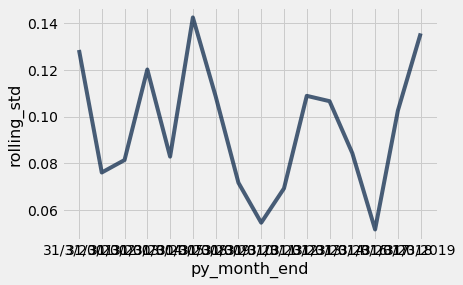

In [11]:
mar=seasonal_selected.where('py_month_end',are.containing('/3/'))

mar.select('py_month_end', 'rolling_std').where('rolling_std', are.between(0.05,0.15)).plot('py_month_end')

**THE FOLLOWING PART IS ARIMA MODEL**






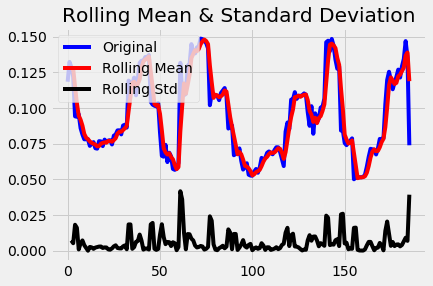

Results of Dickey-Fuller Test:
Test Statistic                  -2.977980
p-value                          0.037003
#Lags Used                       0.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


In [12]:
################THIS PART IS TO TEST DATA STATIONARITY############
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=3).mean()
    rolstd = pd.Series(timeseries).rolling(window=3).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(seasonal_selected.where('rolling_std', are.between(0.05,0.15)).column('rolling_std'))
#test_stationarity(seasonal_selected.column('new_rollingstd_last_12'))

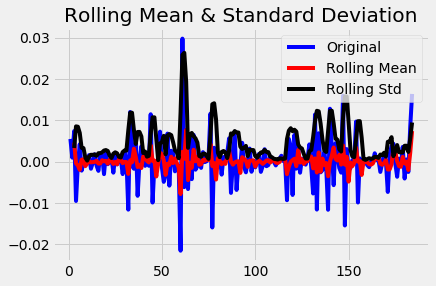

Results of Dickey-Fuller Test:


MissingDataError: ignored

In [13]:
##############YOU CAN INGORE THIS###############
ts=seasonal_selected.where('rolling_std', are.between(0.05, 0.15)).column('rolling_std')
#ts_log=np.log(ts)
#ts_log_diff=np.diff(ts_log)
#plt.plot(ts_diff)

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(ts,freq=3)
residue=decomposition.resid
#residue.dropna(inplace=True)
test_stationarity(residue)


In [14]:
########THIS IS TO PRINT SUMMARY REPORT############
from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm
model = ARIMA(ts, order=(2,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  184
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 550.456
Method:                       css-mle   S.D. of innovations              0.012
Date:                Sat, 07 Dec 2019   AIC                          -1088.912
Time:                        11:32:59   BIC                          -1069.622
Sample:                             2   HQIC                         -1081.094
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.176e-06    1.6e-05      0.073      0.942   -3.02e-05    3.26e-05
ar.L1.D2.y    -0.9631      0.098     -9.839      0.000      -1.155      -0.771
ar.L2.D2.y    -0.0459      0.081     -0.565      0.5

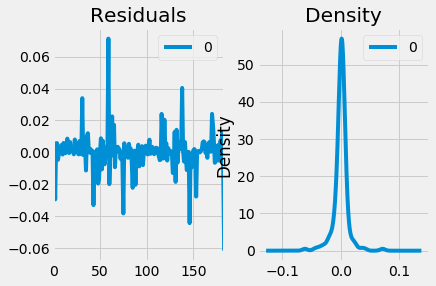

In [15]:
##############RESUDUAL PLOT AND DENSITY PLOT TO SHOW OUR MODEL IS UNBAISED##############
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])

residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

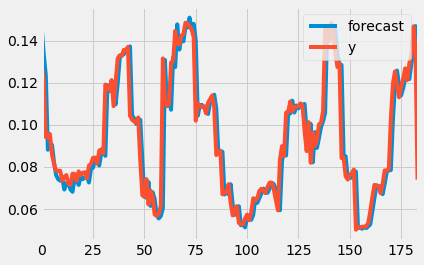

In [16]:
#######YOU CAN IGNORE THIS########
model_fit.plot_predict(dynamic=False)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  140
Model:                     ARMA(3, 3)   Log Likelihood                 444.138
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sat, 07 Dec 2019   AIC                           -872.275
Time:                        11:35:57   BIC                           -848.742
Sample:                             0   HQIC                          -862.712
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0967      0.008     12.316      0.000       0.081       0.112
ar.L1.y        2.6077      0.102     25.611      0.000       2.408       2.807
ar.L2.y       -2.3367      0.195    -12.001      0.0

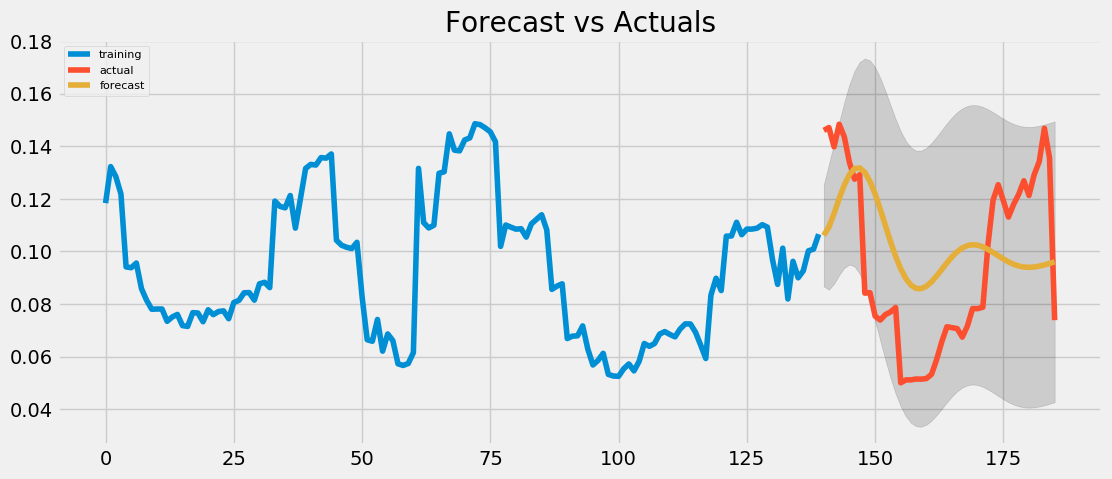

In [17]:
#############*****THIS CELL GIVES BOTH SUMMARY REPORT AND PREDICTION VISUALISATION******##########
import pandas as pd    
import numpy as np 
# train_array=ts[:140]
# test_array=ts[140:]
# train=pd.DataFrame(train_array)
# test=pd.DataFrame(test_array)

train=pd.DataFrame(ts)[:140]
test=pd.DataFrame(ts)[140:]

# print('*******',train)
# print('*******',test)

# Build Model
model = ARIMA(np.array(train), order=(3, 0, 3))

fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(46, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# print("lower_ind: ", lower_series.index, "lower: ", lower_series)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
###########THIS CELL RETURNS FORECAST ACCURACY INFORMATION##############
def forecast_accuracy(forecast, actual):
    #print('******', np.abs(forecast - actual)/np.abs(actual))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))   # MAPE
    print('mean absolute percentage error :',mape)
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)  # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({ 'mean absolute percentage error': mape, 'mean error':me, 'mean absolute error': mae, 
            'mean percentage error': mpe, 'root mean square error':rmse,  
            'pairwise correlation coefficient':corr, 'minmax':minmax})

forecast_accuracy(np.array(fc), ts[140:])
# print(np.array(fc),np.array(test))
# print(np.corrcoef(fc, test)) 


mean absolute percentage error : 0.3578717297334101


{'mean absolute error': 0.02906045779132941,
 'mean absolute percentage error': 0.3578717297334101,
 'mean error': 0.006497241739093782,
 'mean percentage error': 0.1875699647155337,
 'minmax': 0.26301342780378045,
 'pairwise correlation coefficient': array([[1.        , 0.38888239],
        [0.38888239, 1.        ]]),
 'root mean square error': 0.03117137038738789}